# HCAS R notebook 03: turnover rate and PPR

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 20 May 2016

**Note**: this notebook can also be viewed at https://github.com/eric542/hcas

## Summary

This notebook investigates the aspect of variable rate of (RS) turnover along a given ENV gradient, and how the PPR approach deals with it.

## Background

### GDM in ecological settings

A specific characteristic of GDM is its ability to compensate for a variable rate of (species) turnover along a particular gradient. An illustrative example is that of the number of species (dissimilarity measure) as a function of precipitation: at the dry end of this (ENV) gradient, 2 sites separated by a given (ENV) distance will have a relatively large dissimilarity (in terms of species composition) compared to 2 sites separated by the same distance but located at the wet end of the precipitation gradient. 

The GDM will compensate for this effect by essentially transforming the ENV (precipitation) variable in such a way as to increase the (transformed) ENV distance at the dry end of the gradient (to match the increased dissimilarity) while reducing the (transformed) ENV distance at the wet end of the gradient (to match the reduced dissimilarity measure).

The GDM formula implementing this transformation is as follows, with $x_p^{\ast(i)}$ representing the $p$-th ENV variable at the $i$-th site, and $\delta^{(ij)}$ representing the (ecological) distance between two sites $i$ and $j$ (please refer to the '*HCAS Activity 3a(1) Methods Document'*, Sec. 1.2, for more detail):

$$
\delta^{(ij)} = \alpha + \sum_{p=1}^{P} \sum_{k=1}^{K} a_{pk} \cdot \underbrace{
\Big|\ f_{pk} \big( x_p^{\ast(i)} \big) - f_{pk} \big( x_p^{\ast(j)} \big) \Big|
}_{\Delta x_p^{(ij)}}
$$

Here, the (I-splines) functions $f_{pk}(\cdot)$ transform the ENV variable $x_p^{\ast}$ so that the resulting (transformed) ENV distance $\Delta x_p^{(ij)}$ "appears" larger in places along the ENV gradient where the (species) dissimilarity measure is larger (and/or vice versa), thereby leading to a larger ecological distance $\delta$. In the specific example of precipitation, one would thus expect $\delta$ to be larger for the 2 sites at the dry end of the precipitation gradient, compared to the 2 sites located at the wet end of the same gradient. 

### PPR in HCAS

Typically, the GDM approach was developped principally in conjunction with ecological modelling problems to achieve the transformation discussed above. On the other hand, PPR is a generic statistical (regression) method not specifically tailored to ecological applications. If PPR is used instead of the GDM method for ENV space modelling, it would be of interest to gauge to what extent PPR is able to reproduce this compensation for variable turnover rates. This notebook is written specifically to test this, using the HCAS dataset of RS and ENV variables.

It is relatively easy to get a feel for what the transformed ENV variables look like under the GDM approach: the transformed variables $f_{pk} ( x_p^{\ast} )$ can be inspected / plotted directly. On the other hand, PPR applies a nonlinear transformation (ridge function) to a *linear combination* of the ENV variables for each ridge term, thereby making it difficult to see how each ENV variable is being processed.

To circumvent this issue, we will use an "indirect" approach where the RS distance is investigated as a function of changes made to a single ENV variable (while keeping all other variables constant). The approach can be summarised as follows:

1. Set all ENV variables to some constant (we'll use their median values, as calculated from the HCAS dataset)
- For a single specific ENV variable, select an interval (of given width) along its gradient
- Transform the two end points of this interval using PPR
- Calculate the distance between the two (transformed) end points in the PPR-transformed ENV space
- Shift the interval slightly in ENV space and repeat points 3. and 4., until the interval reaches the end of the gradient
- Plot the line of (transformed ENV) distances as a function of the ENV variable (i.e., as a function of the interval's location along the ENV gradient).

The final result (line of transformed distances vs. ENV gradient) then indicates how the RS distance varies as a function of where we are located along the ENV gradient. Again, taking precipitation as an example, one would expect this line to show greater (RS) distances at the dry end of the precipitation (ENV) gradient and smaller distances at the wet end of the gradient.

## Miscellaneous

Some preliminary `R` functions and definitions.

In [1]:
library(repr)
options(repr.plot.width=6, repr.plot.height=6)
base_path = "//OSM-09-cdc.it.csiro.au/OSM_CBR_DP_RSII_processing/Eric/HCAS/"

## Results

Let's load up existing PPR results:

In [2]:
print( load(paste(base_path,"HCAS_vars.Rdata",sep='')) )

[1] "site_latlon"             "site_env_vars"          
[3] "site_GDMenv_vars"        "site_RSorig_vars"       
[5] "site_RSpca_vars"         "site_indx_NonZeroPCA"   
[7] "pind_data_NonZeroPCA"    "TH_dist_data_NonZeroPCA"


In [3]:
print( load(paste(base_path,"hcas_eda05_PPR_subs20_scaledENV_supsmu_bass1_ppr.Rdata",sep='')) )

[1] "ppr_out"


These PPR results were obtained with a subset of the 986,549 site pairs available in the HCAS dataset. To produce results below, we thus need to subsample the HCAS sites as done when the PPR was applied:

In [4]:
n_pairs = dim(pind_data_NonZeroPCA)[1]
pair_indx_vec = seq(1, n_pairs, by=20)   # indices of pairs subset 
tmp = pind_data_NonZeroPCA[pair_indx_vec,]
site_indx_vec = sort( unique( as.vector( tmp )))   # indices of selected sites
n_sites = length(site_indx_vec)

site_env_vars = site_env_vars[site_indx_vec,]

n_env_vars = dim(site_env_vars)[2]       # nr of ENV variables
env_names_vec = colnames(site_env_vars)  # their names

We also need to work out what scaling parameters were used to scale the ENV variables during PPR:

In [5]:
tmp = attributes( scale(site_env_vars) )
env_scaled_center = tmp[[3]]
env_scaled_scale = tmp[[4]]

We can now determine the range of values for each ENV variable (let's use their 98-th percentile range) and their average values (e.g. their median):

In [6]:
env_quant = apply(site_env_vars,2,quantile,c(.01,.5,.99))

# Example:
cat("Median for 1st ENV variable is:",env_quant[2,1],"\n")
cat("Range of values for 1st ENV variable is:",env_quant[1,1],"...",env_quant[3,1],"\n")

Median for 1st ENV variable is: 41.2445 
Range of values for 1st ENV variable is: 2.508537 ... 609.3534 


Let's now plot the line of RS distances vs. ENV gradient, using the precipitation variable as example. In the HCAS set of ENV variables, the (average) precipitation variable is denoted `ptamn`:

In [7]:
precip_indx = which(env_names_vec=='ptamn')
precip_indx

[1] 14

We can select a sequence of points along the precipitation gradient (i.e. within the range of `ptamn` values); these will be the starting points of our precipitation (ENV) intervals:

In [8]:
n_interv = 30
env_interv = seq(env_quant[1,precip_indx], env_quant[3,precip_indx], len=n_interv)

Next, let's define the vector of ENV variables, setting all variables to their median:

In [9]:
env_vars = env_quant[2,]

Let's now define the width of our intervals in ENV space for the precipitation variable, using e.g. a value of 25% of the total range along that precipitaion gradient:

In [10]:
dp = 0.25 * (env_quant[3,precip_indx] - env_quant[1,precip_indx])

Now, a (fairly inefficient) piece of code to calculate the RS distance for each interval is as follows:

In [11]:
PPRenv_dist_vec = rep(NA, n_interv)
for ( ii in 1:n_interv ) {
    env_vars[precip_indx] = env_interv[ii]
    tmp = (env_vars-env_scaled_center)/env_scaled_scale
    rspc1_vec = predict(ppr_out, t(as.data.frame(tmp)))     # PPR-predicted RS variables of first end point
    
    env_vars[precip_indx] = env_interv[ii] + dp   # (we're very likely duplicating calculations here!...)
    tmp = (env_vars-env_scaled_center)/env_scaled_scale
    rspc2_vec = predict(ppr_out, t(as.data.frame(tmp)))     # PPR-predicted RS variables of second end point
    
    PPRenv_dist_vec[ii] = sum(abs(rspc2_vec - rspc1_vec))   # resulting (PPR-predicted) RS distance
}

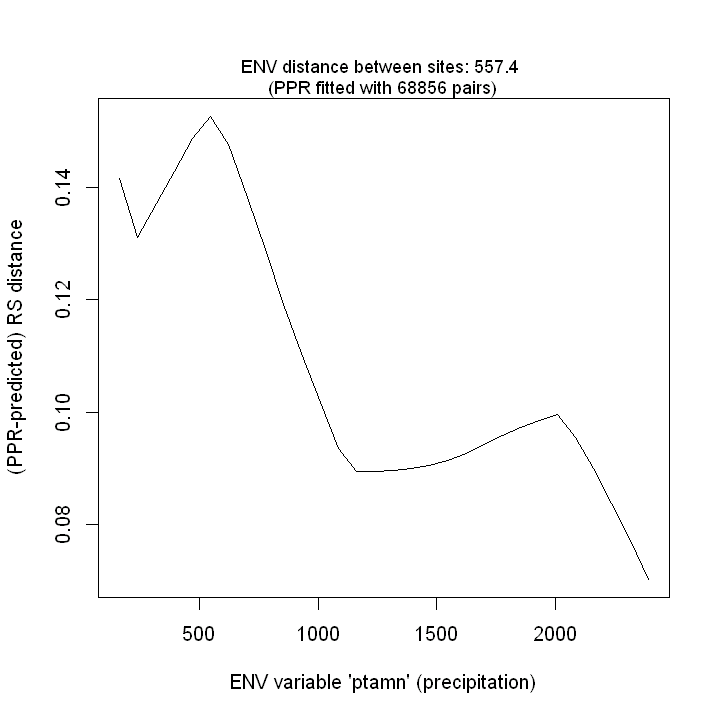

In [12]:
plot(env_interv, PPRenv_dist_vec, xlab="ENV variable 'ptamn' (precipitation)", 
     ylab="(PPR-predicted) RS distance", type="l")
mtext(paste("ENV distance between sites:",round(dp,2),"\n(PPR fitted with",n_sites,"pairs)"), cex=.9)

Overall, we seem to get a plausible result, with the RS distance decreasing as the precipitation increases. This effect is even more pronounced with the variable `ptimn`, i.e. the average minimum precipitation value.

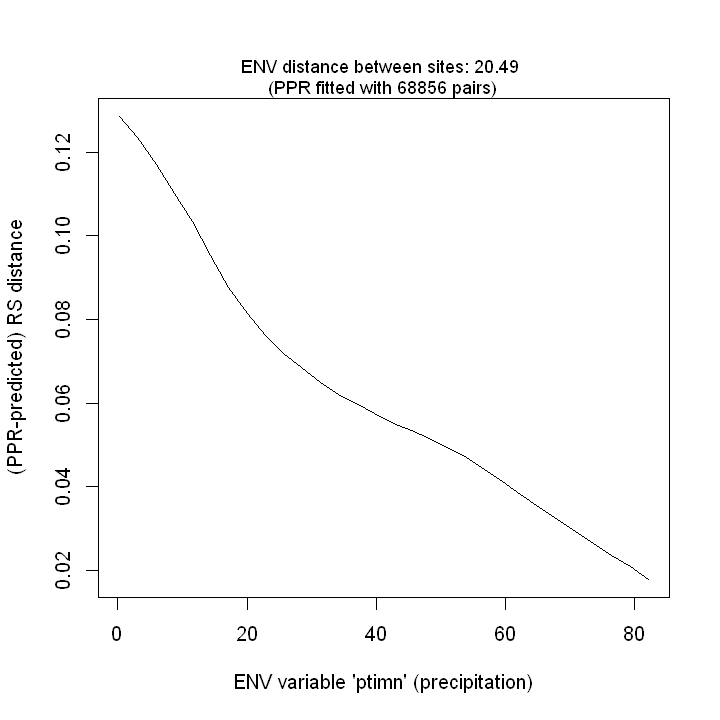

In [13]:
indx = which(env_names_vec=='ptimn')
env_interv = seq(env_quant[1,indx], env_quant[3,indx], len=n_interv)
env_vars = env_quant[2,]
dp = 0.25 * (env_quant[3,indx] - env_quant[1,indx])

PPRenv_dist_vec = rep(NA, n_interv)
for ( ii in 1:n_interv ) {
    env_vars[indx] = env_interv[ii]
    tmp = (env_vars-env_scaled_center)/env_scaled_scale
    rspc1_vec = predict(ppr_out, t(as.data.frame(tmp)))     # PPR-predicted RS variables of first end point
    
    env_vars[indx] = env_interv[ii] + dp   # (we're very likely duplicating calculations here!...)
    tmp = (env_vars-env_scaled_center)/env_scaled_scale
    rspc2_vec = predict(ppr_out, t(as.data.frame(tmp)))     # PPR-predicted RS variables of second end point
    
    PPRenv_dist_vec[ii] = sum(abs(rspc2_vec - rspc1_vec))   # resulting (PPR-predicted) RS distance
}

plot(env_interv, PPRenv_dist_vec, xlab="ENV variable 'ptimn' (precipitation)", 
     ylab="(PPR-predicted) RS distance", type="l")
mtext(paste("ENV distance between sites:",round(dp,2),"\n(PPR fitted with",n_sites,"pairs)"), cex=.9)

Other variables, such as elevation (`elvr1000mn`) have a reversed relationship with RS distance:

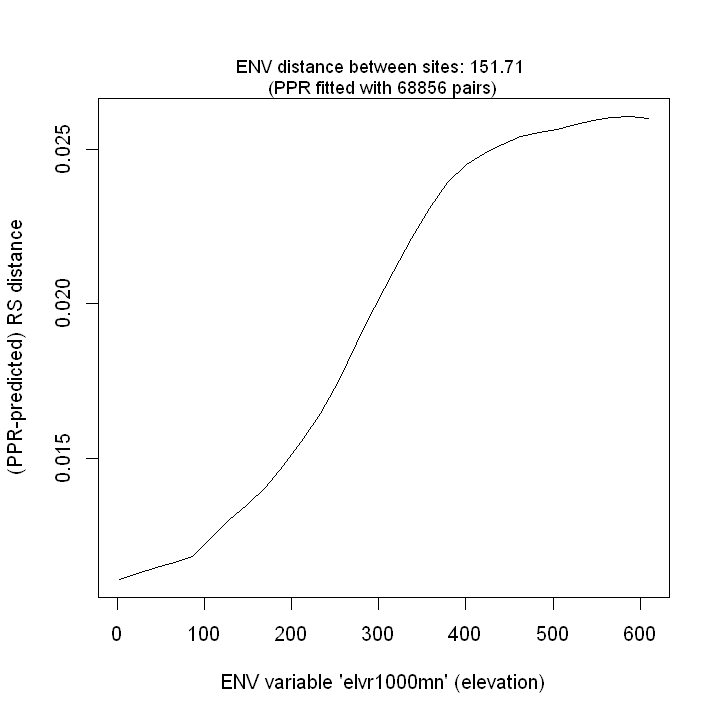

In [14]:
indx = which(env_names_vec=='elvr1000mn')
env_interv = seq(env_quant[1,indx], env_quant[3,indx], len=n_interv)
env_vars = env_quant[2,]
dp = 0.25 * (env_quant[3,indx] - env_quant[1,indx])

PPRenv_dist_vec = rep(NA, n_interv)
for ( ii in 1:n_interv ) {
    env_vars[indx] = env_interv[ii]
    tmp = (env_vars-env_scaled_center)/env_scaled_scale
    rspc1_vec = predict(ppr_out, t(as.data.frame(tmp)))     # PPR-predicted RS variables of first end point
    
    env_vars[indx] = env_interv[ii] + dp   # (we're very likely duplicating calculations here!...)
    tmp = (env_vars-env_scaled_center)/env_scaled_scale
    rspc2_vec = predict(ppr_out, t(as.data.frame(tmp)))     # PPR-predicted RS variables of second end point
    
    PPRenv_dist_vec[ii] = sum(abs(rspc2_vec - rspc1_vec))   # resulting (PPR-predicted) RS distance
}

plot(env_interv, PPRenv_dist_vec, xlab="ENV variable 'elvr1000mn' (elevation)", 
     ylab="(PPR-predicted) RS distance", type="l")
mtext(paste("ENV distance between sites:",round(dp,2),"\n(PPR fitted with",n_sites,"pairs)"), cex=.9)

... while yet other variables, such as `kao20mn` (whatever that represents), have more "wacky" responses:

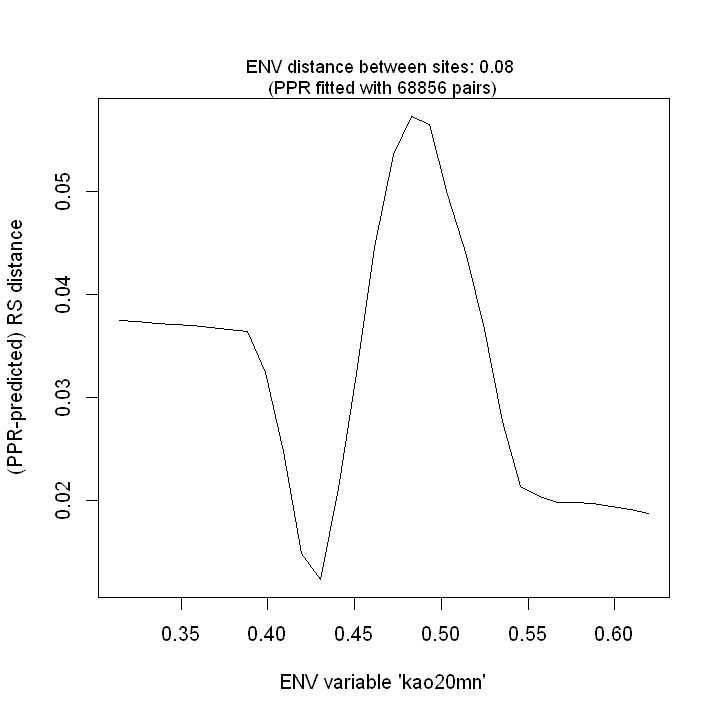

In [16]:
indx = which(env_names_vec=='kao20mn')
env_interv = seq(env_quant[1,indx], env_quant[3,indx], len=n_interv)
env_vars = env_quant[2,]
dp = 0.25 * (env_quant[3,indx] - env_quant[1,indx])

PPRenv_dist_vec = rep(NA, n_interv)
for ( ii in 1:n_interv ) {
    env_vars[indx] = env_interv[ii]
    tmp = (env_vars-env_scaled_center)/env_scaled_scale
    rspc1_vec = predict(ppr_out, t(as.data.frame(tmp)))     # PPR-predicted RS variables of first end point
    
    env_vars[indx] = env_interv[ii] + dp   # (we're very likely duplicating calculations here!...)
    tmp = (env_vars-env_scaled_center)/env_scaled_scale
    rspc2_vec = predict(ppr_out, t(as.data.frame(tmp)))     # PPR-predicted RS variables of second end point
    
    PPRenv_dist_vec[ii] = sum(abs(rspc2_vec - rspc1_vec))   # resulting (PPR-predicted) RS distance
}

plot(env_interv, PPRenv_dist_vec, xlab="ENV variable 'kao20mn'", 
     ylab="(PPR-predicted) RS distance", type="l")
mtext(paste("ENV distance between sites:",round(dp,2),"\n(PPR fitted with",n_sites,"pairs)"), cex=.9)

Results from a similar analysis, achieved on the basis of PPR fitted to the entire HCAS dataset (986,549 site pairs, involving 422,323 sites) have been calculated offline, and can be found in the file 'HCAS_PPR_var_turnover.pdf'. These results were also computed for 4 different interval widths, corresponding to 5, 10, 25 and 50% of the ENV variables' range. Note that the use of the full dataset appears to substantially alter the responses, e.g. compared to the results achieved in this notebook.

## Bottom line

Perhaps more importantly than the exact RS (distance) responses obtained for each ENV variable, these results demonstrate that PPR has an inherent capacity to compensate (or at least partially account for) varying rates of (RS) turnover along a given ENV gradient. 

This is likely to be a reassuring insight into PPR from an ecological perspective. The possible benefits and improvements achived through the use of PPR in environmental / ecological applications (e.g. where GDM is currently being used) would represent an interesting topic of further research.